# Decision Tree Classifiers
<p>This Notebook gives an overview of DecisionTrees with scikit learn. In it are examples of:

<ul>
<li>Build a basic decision tree</li>
<li>Plotting the decision surface of a decision tree</li>
<li>Visualing the decision tree</li>
<li>Overfitting (as viewed by decision surfaces) of decision trees with no limits on depth and leaf size</li>
<li>Searching for optimal parameters of a decision tree</li>
<li>Using decision tree output to assess feature importance</li>
</ul>

</p>

### Build a Tree on Simulated Data

In [8]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#These all need to be installed to both run and visualize a tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

from io import StringIO
%matplotlib inline


<p>Here I generate some random data $X=<X1,X2>$ with $Y \in [0,1]$
</p>

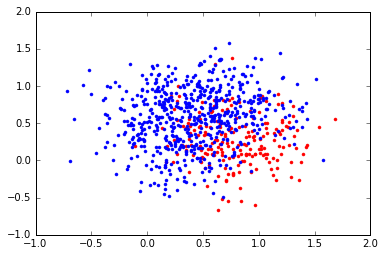

In [4]:
'''
Random data example 
'''
n=200


#First Generate the data

m=[[0.25,0.75],[0.75,0.75],[0.75,0.25],[0.25,0.25]]
s=.1
X1=pd.DataFrame(np.random.multivariate_normal([m[0][0],m[0][1]],[[s,0],[0,s]],n), columns=['x1','x2'])
X1['y']=np.zeros(n)
X2=pd.DataFrame(np.random.multivariate_normal([m[1][0],m[1][1]],[[s,0],[0,s]],n), columns=['x1','x2'])
X2['y']=np.zeros(n)
X3=pd.DataFrame(np.random.multivariate_normal([m[2][0],m[2][1]],[[s,0],[0,s]],n), columns=['x1','x2'])
X3['y']=np.ones(n)
X4=pd.DataFrame(np.random.multivariate_normal([m[3][0],m[3][1]],[[s,0],[0,s]],n), columns=['x1','x2'])
X4['y']=np.zeros(n)

dat=X1.append(X2,ignore_index=True)
dat=dat.append(X3,ignore_index=True)
dat=dat.append(X4,ignore_index=True)

plt.plot(dat['x1'][(dat['y']==1)],dat['x2'][(dat['y']==1)],'r.')
plt.plot(dat['x1'][(dat['y']==0)],dat['x2'][(dat['y']==0)],'b.')

<p>

</p>

<p>
Now lets build a tree on our sample data.<br><br>

Documentation can be found here:
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
<br>
Also, here is another useful example:
http://nbviewer.ipython.org/github/sujitpal/statlearning-notebooks/blob/master/src/chapter8.ipynb

</p>

In [5]:
#We want Entropy as our splitting criteria
clf = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=1,max_depth=3)
clf = clf.fit(dat.drop('y',1), dat.y)

<p>Building a tree is pretty easy. Visualizing the tree takes a little extra work and a few extra packages.<br><br>
To plot it is necessary to install Pydot as well as graphviz: http://www.graphviz.org/
If you have homebrew installed, run: brew install graphviz in the command line.
</p>

In [10]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#Image(graph.create_png())
graph.write_pdf("iris.pdf")


InvocationException: GraphViz's executables not found

<p>The decision surface can be derived by using the predict function and not having to parse the DT rules.<br><br>
This code was adapted from http://scikit-learn.org/0.11/auto_examples/tree/plot_iris.html



</p>

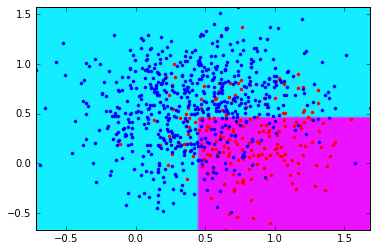

In [11]:
X=dat.drop('y',1)
y=dat.y

plot_step = 0.02

x_min, x_max = X['x1'].min(), X['x1'].max()
y_min, y_max = X['x2'].min(), X['x2'].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.subplot(111)

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.cool)
plt.plot(dat['x1'][(dat['y']==1)],dat['x2'][(dat['y']==1)],'r.')
plt.plot(dat['x1'][(dat['y']==0)],dat['x2'][(dat['y']==0)],'b.')


<p>The above is a pretty simple tree, which we can see in the above plot.<br><br>

As we allow for more complex trees, visualing the tree becomes very cumbersome, but we can still look at the decision surface. 


</p>

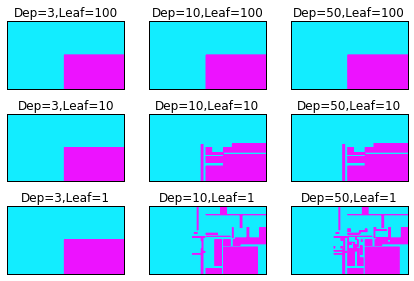

In [12]:
def treeComplex(X,y,leaf,dep,i):
    clf = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=leaf,max_depth=dep)
    clf = clf.fit(X,y)
    plot_step = 0.02
    x_min, x_max = X['x1'].min(), X['x1'].max()
    y_min, y_max = X['x2'].min(), X['x2'].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax = fig.add_subplot(3,3,i)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.cool)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.title('Dep={},Leaf={}'.format(dep,leaf))
              
leafs=[100,10,1]
deps=[3,10,50]

i=1
fig=plt.figure()

for l in leafs:
    for d in deps:
        treeComplex(dat.drop('y',1),dat.y,l,d,i)
        i+=1
        
fig.tight_layout()


<p>As we let the trees grow without any restrictions, we notice that the decision surface gets very fragmented. This defies our intuition that nearest neighbors of a point should have the same class assignment. Since we know that this data was generated from a few simple normal mixtures, we should understand that these more complex surfaces are terribly over fit.
<br><br>
Beyond toy examples, let's see this on real data.
</p>

### Decision Tree on Real Data
<p>We don't just want to build a tree, we want to optimize the configuration of the tree. We'll use AUC as a metric on our test set and vary the max_depth and min_leaf_size. <br><br>

The underlying data has a very rare outcome (less than 5%) so we'll down sample the data first to reach a 50/50 split.


</p>

In [33]:
dep

NameError: name 'dep' is not defined

In [30]:
from sklearn.metrics import confusion_matrix,roc_auc_score
import sys
sys.path.append("C:/Users/kevin/Documents/GitHub/DS_course/ipython")
import imp
import course_utils as bd
imp.reload(bd)

#Load data and downsample for a 50/50 split, then split into a train/test
f='C:/Users/kevin/Documents/GitHub/DS_course/datasets/ads_dataset_cut.txt'

train_split = 0.5
tdat = pd.read_csv(f,header=0,sep='\t')

moddat = bd.downSample(tdat,'y_buy',9)
#We know the dataset is sorted so we can just split by index
train = moddat[:int(np.floor(moddat.shape[0]*train_split))]
test = moddat[int(np.floor(moddat.shape[0]*train_split)):]

def testTrees(X_train,y_train,X_test,y_test,dep,leaf,auc):
    clf = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=leaf,max_depth=dep)
    clf = clf.fit(X_train,y_train)
    if (auc==0):
        cm = confusion_matrix(clf.predict(X_test),y_test)
        return (cm[0][0]+cm[1][1])/float(sum(cm))
    else:
        return roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])
    

    

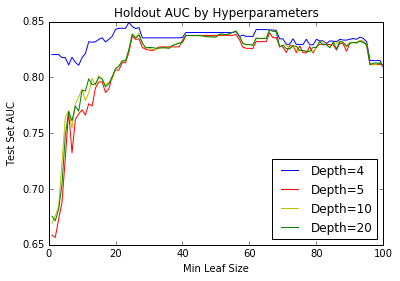

In [31]:
lab='y_buy'

depths=[4,5,10,20]
leaves=np.arange(1,101)

#Run all of the options
run=1
if (run==1):
    #Initialize dictionary of results
    res=dict()
    for d in depths:
        res[d]=list()

    #Now train and get results for each option
    for d in depths:
        for l in leaves:
            res[d].append(testTrees(train.drop(lab,1),train[lab],test.drop(lab,1),test[lab],d,l,1))


#Now plot            
fig = plt.figure()
ax=fig.add_subplot(111)
plt.plot(leaves,res[depths[0]],'b-',label='Depth={}'.format(depths[0]))
plt.plot(leaves,res[depths[1]],'r-',label='Depth={}'.format(depths[1]))
plt.plot(leaves,res[depths[2]],'y-',label='Depth={}'.format(depths[2]))
plt.plot(leaves,res[depths[3]],'g-',label='Depth={}'.format(depths[3]))
plt.legend(loc=4)
ax.set_xlabel('Min Leaf Size')
ax.set_ylabel('Test Set AUC')
plt.title('Holdout AUC by Hyperparameters')

<p>The above plot shows how holdout AUC varies by parameters. As we generally expect with most hyper-parameter searches, there is a "sweet spot" between letting the model be flexible and over fitting. Here we see that as long as we restrict the min_leaf_size, the max_depth doesn't affect the optimal choice too much.<br><br>

We might want to peek at the tree to determine which features it thinks are important. The DT class objects actually have an attribute that gives each feature a score for how important it is in building the tree. 


</p>

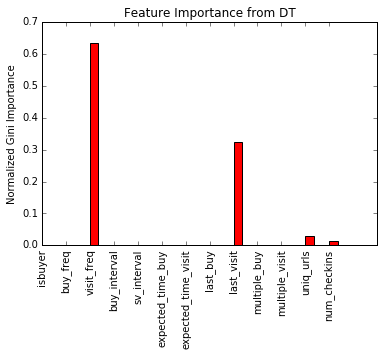

In [45]:
'''
The tree gives us a useful tool for analying feature importance
'''

clf = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=100,max_depth=20)
clf = clf.fit(train.drop(lab,1),train[lab])


fig, ax = plt.subplots()
width=0.35
#ax.bar(train.drop(lab,1).columns.values, clf.feature_importances_, width, color='r')
ax.bar(np.arange(13), clf.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(clf.feature_importances_)))
ax.set_xticklabels(train.drop(lab,1).columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

